# <center><span style='color:green'> Household Electricity Consumption </span></center>

## Problem Statement

* Predict the household electricity consumption
* Regression problem

## 1 <span style='color:red'>|</span> Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#for modeling
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score , r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingRegressor , RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor

#database
import pymongo

#save the model
import pickle

#to read data
import zipfile

## 2 <span style='color:red'>|</span> Load Dataset

In [2]:
zip_file_path = "cosumption_data.zip"
file_name = "household_power_consumption.txt"

with zipfile.ZipFile(zip_file_path, 'r') as zip_file:
    file_list = zip_file.namelist()
    for file in file_list:
        if file == file_name:
            with zip_file.open(file_name) as csv_file:
                df = pd.read_csv(csv_file, delimiter=';')

In [3]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [4]:
df.shape

(2075259, 9)

* Taking a sample of 60000 as data is too large 

In [5]:
df_sample = df.sample(60000)
df_sample.shape

(60000, 9)

## 3 <span style='color:red'>|</span> Exploratory Data Analysis

In [6]:
df_sample.columns

Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [7]:
df_sample.drop(['Date','Time'], axis=1, inplace=True)

In [8]:
df_sample.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
421561,1.420,0.142,235.840,6.000,0.000,2.000,17.0
409263,0.892,0.000,242.200,3.600,0.000,0.000,0.0
1668482,1.806,0.068,239.900,7.400,1.000,0.000,18.0
1022146,2.382,0.000,238.960,9.800,0.000,0.000,17.0
1230037,0.506,0.086,241.500,2.200,0.000,0.000,0.0


In [9]:
df_sample.sample(10)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
2018040,0.350,0.100,243.430,1.400,0.000,0.000,1.0
1809754,0.528,0.164,239.790,2.200,0.000,1.000,0.0
2057826,2.51,0.196,232.32,10.8,0.0,1.0,17.0
976138,0.334,0.092,245.030,1.400,0.000,1.000,0.0
483074,0.262,0.000,244.880,1.200,0.000,0.000,0.0
1983392,0.382,0.294,238.600,2.000,0.000,1.000,1.0
709766,5.312,0.116,234.610,22.800,0.000,37.000,17.0
1048077,0.854,0.140,243.720,3.600,0.000,0.000,0.0
264184,0.168,0.086,239.960,0.800,0.000,0.000,0.0
1731035,1.662,0.050,240.370,6.800,0.000,0.000,18.0


In [10]:
df_sample.dtypes

Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

#### 3.1 <span style='color:red'>|</span> Check any special character and handle them 

In [11]:
character_check = any(not value.isnumeric() for value in df_sample['Global_active_power'])
character_check

True

In [12]:
character = [value for value in df_sample['Global_active_power'] if not str(value).replace('.','',1).isnumeric()]
set(character)

{'?'}

In [13]:
#Check character in dataframe
special_char = df_sample[df_sample['Global_active_power']=='?']
special_char

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
1713604,?,?,?,?,?,?,NaN
1936217,?,?,?,?,?,?,NaN
1619482,?,?,?,?,?,?,NaN
191498,?,?,?,?,?,?,NaN
1936625,?,?,?,?,?,?,NaN
...,...,...,...,...,...,...,...
1933985,?,?,?,?,?,?,NaN
1930619,?,?,?,?,?,?,NaN
1310481,?,?,?,?,?,?,NaN
1936749,?,?,?,?,?,?,NaN


* 737/60000 rows and 7/7 columns has special character in it

In [14]:
(737/60000)*100

1.2283333333333333

In [15]:
#drop the data having special character
print("Data before removal of special character :", df_sample.shape)
df_sample.drop(special_char.index, axis=0, inplace=True)
print("Data after removal of special character :", df_sample.shape)

Data before removal of special character : (60000, 7)
Data after removal of special character : (59258, 7)


#### 3.2 <span style='color:red'>|</span> Check duplicates

In [16]:
df_sample.duplicated().sum()

284

* 265 duplicates record found

In [17]:
print("Data with duplicate records :", df_sample.shape)
df_sample.drop_duplicates(inplace=True)
print("Data withour duplicate records :", df_sample.shape)

Data with duplicate records : (59258, 7)
Data withour duplicate records : (58974, 7)


#### 3.3 <span style='color:red'>|</span> Check null values

In [18]:
df_sample.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

* No null values in dataset

#### 3.4 <span style='color:red'>|</span> Convert dtype of columns

In [19]:
df_sample = df_sample.astype(float)

In [20]:
df_sample.dtypes

Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

#### 3.5 <span style='color:red'>|</span> Combining Features

In [21]:
df_sample['meter'] = df_sample['Sub_metering_1'] + df_sample['Sub_metering_2'] + df_sample['Sub_metering_2']

In [22]:
df_sample.drop(['Sub_metering_1','Sub_metering_2','Sub_metering_3'], axis=1, inplace=True)

In [23]:
df_sample.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'meter'],
      dtype='object')

In [24]:
df_sample.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,meter
421561,1.420,0.142,235.84,6.0,4.0
409263,0.892,0.000,242.20,3.6,0.0
1668482,1.806,0.068,239.90,7.4,1.0
1022146,2.382,0.000,238.96,9.8,0.0
1230037,0.506,0.086,241.50,2.2,0.0


In [25]:
df_sample.describe().T

,count,mean,std,min,25%,50%,75%,max
Global_active_power,58974.0,1.089418,1.051640,0.078,0.310,0.602,1.522,9.21
Global_reactive_power,58974.0,0.123866,0.113106,0.000,0.048,0.100,0.194,1.10
Voltage,58974.0,240.851230,3.228350,224.540,239.010,241.010,242.890,253.35
Global_intensity,58974.0,4.618822,4.417903,0.200,1.400,2.600,6.400,39.60
meter,58974.0,3.668600,13.390616,0.000,0.000,0.000,2.000,182.00


#### 3.6 <span style='color:red'>|</span> Data Distribution

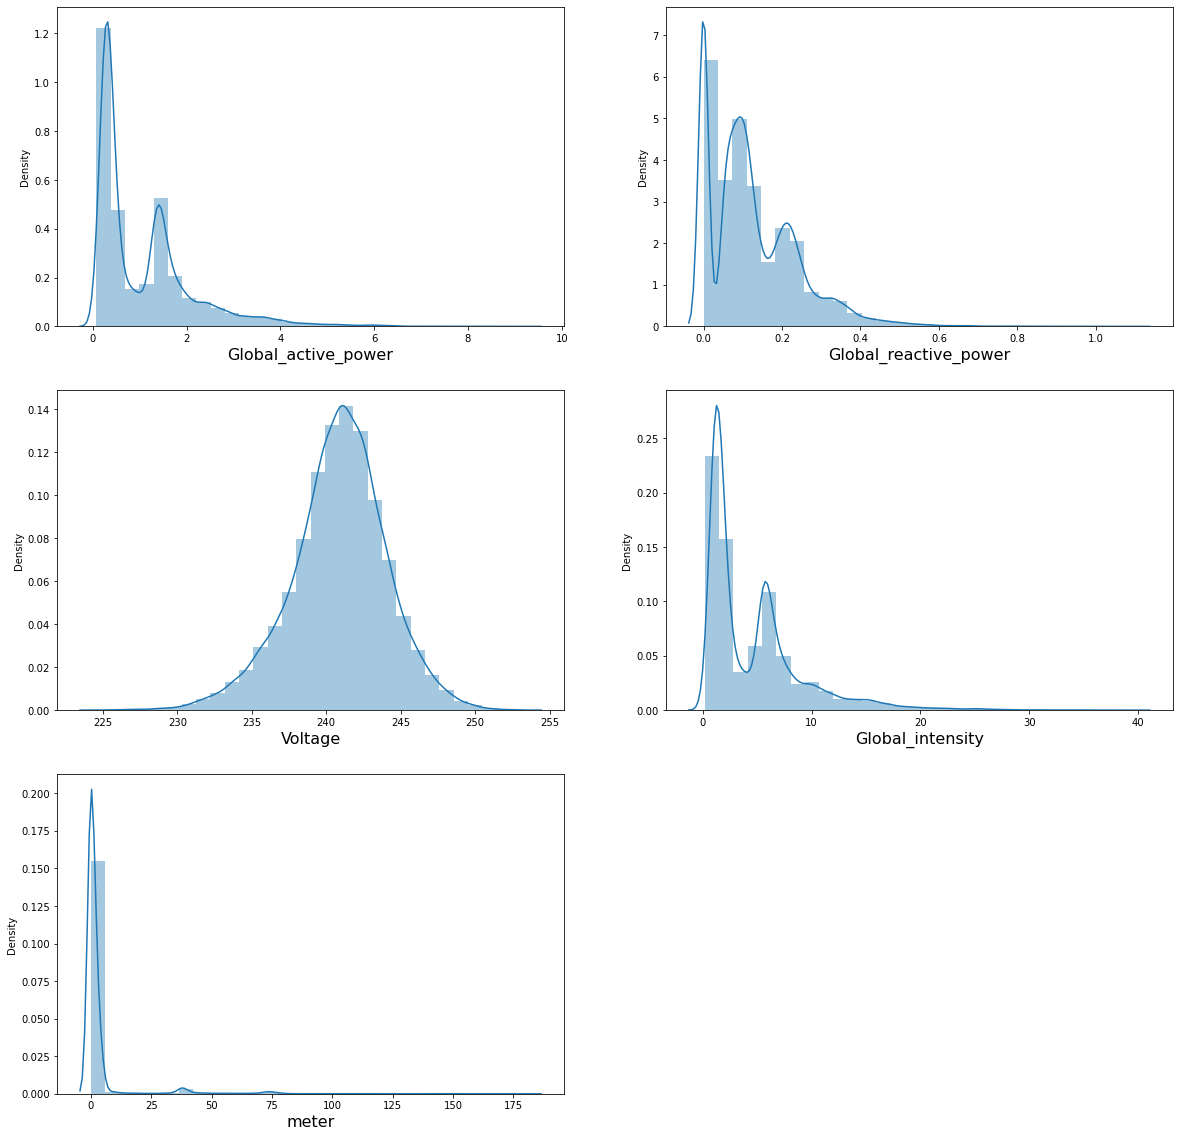

In [26]:
#Data Distribution in each column
plt.figure(figsize=(20,20), facecolor='white')
plotnum =1

for col in df_sample.columns:
    if plotnum <= 5:
        ax = plt.subplot(3,2,plotnum)
        sns.distplot(df_sample[col], bins=30)
        plt.xlabel(col, fontsize=16)
    plotnum += 1
plt.show()

#### 3.7 <span style='color:red'>|</span> Check & Handle outliers

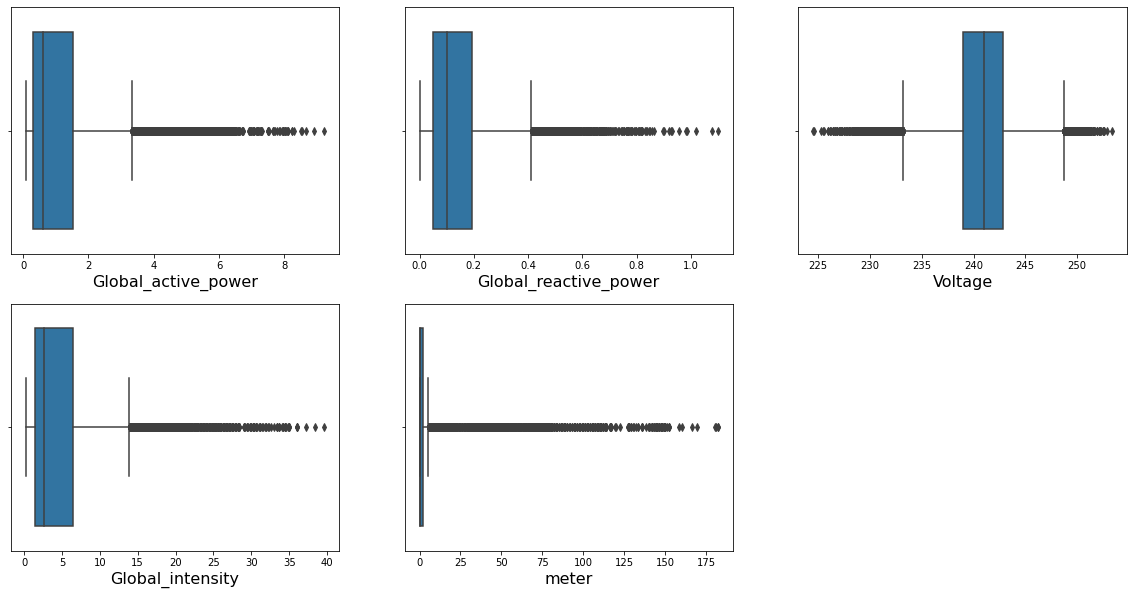

In [27]:
plt.figure(figsize=(20,10))
plotnum = 1

for col in df_sample.columns:
    if plotnum <= 5:
        ax = plt.subplot(2,3,plotnum)
        sns.boxplot(df_sample[col])
        plt.xlabel(col, fontsize=16)
    plotnum += 1
plt.show()

In [28]:
#Handling Outlier

df1 = df_sample.copy()

for col in df1.columns:
    iqr = df1[col].quantile(0.75) - df1[col].quantile(0.25)
    lower_limit = df1[col].quantile(0.25) - (1.5*iqr)
    upper_limit = df1[col].quantile(0.75) + (1.5*iqr)
    
    df1[col] = np.where(df1[col]>upper_limit,upper_limit,np.where(df1[col]<lower_limit,lower_limit,df1[col]))

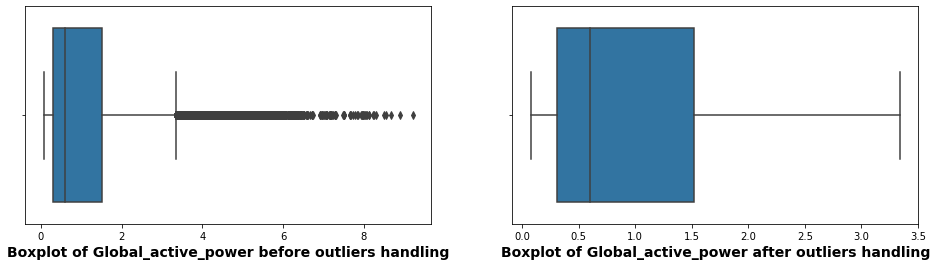

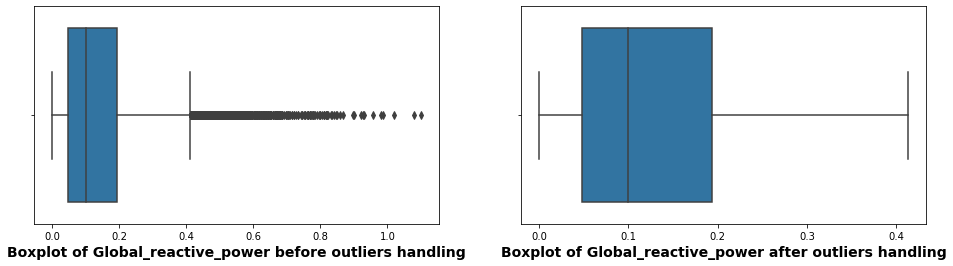

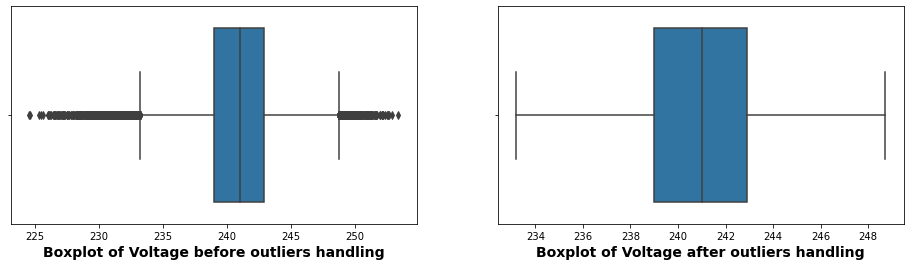

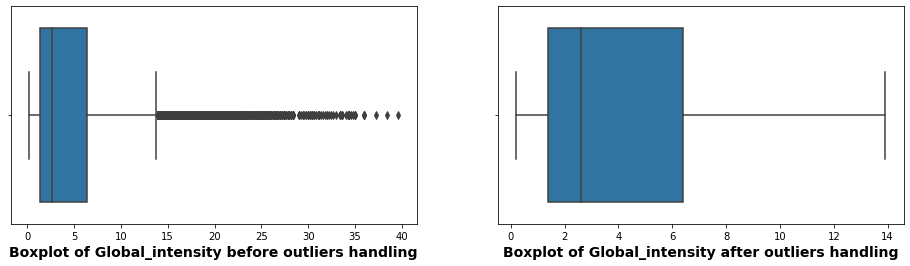

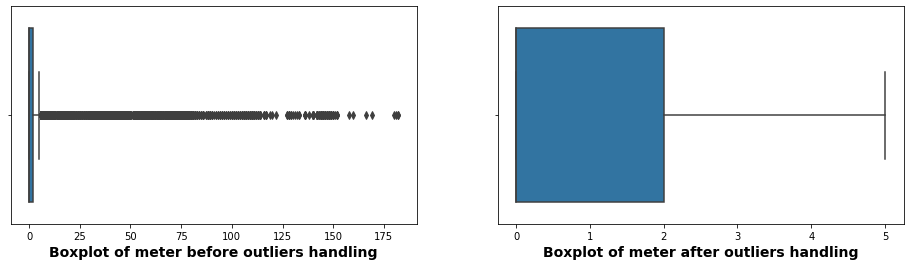

In [29]:
#compare the distribution across quantile

for col in df1.columns:
    
    plt.figure(figsize=(16,4))
    plt.subplot(121)
    sns.boxplot(df_sample[col])
    plt.xlabel(f"Boxplot of {col} before outliers handling", fontsize=14, fontweight='bold')
    
    plt.subplot(122)
    sns.boxplot(df1[col])
    plt.xlabel(f"Boxplot of {col} after outliers handling", fontsize=14, fontweight='bold')

## 4 <span style='color:red'>|</span> Model Building

In [30]:
x= df1.drop('meter', axis=1)
y = df1['meter']

In [31]:
x.shape,y.shape

((58974, 4), (58974,))

#### 4.1 <span style='color:red'>|</span> Train Test Split Dataset

In [32]:
x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=42, test_size=0.20)

#### 4.1 <span style='color:red'>|</span> Standardization

In [33]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

#### 4.3 <span style='color:red'>|</span> Modeling

In [34]:
report = []

In [35]:
models = {
    "Linear Regression" : LinearRegression(),
    "Ridge Regression" : Ridge(),
    "Lasso Regression" : Lasso(),
    "Support Vector Regression" : SVR(),
    "Decision Tree Regressor" : DecisionTreeRegressor(),
    "Random Forest Regressor" : RandomForestRegressor()
}


In [36]:
for i in range(len(models)):
    model = list(models.values())[i] 
    model.fit(x_train,y_train)
    
    #prediction
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    #Training data performance
    n = len(y_train)
    k = x_train.shape[1]
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    train_adj_r2 = 1-(((1-train_r2)*(n-1))/(n-k-1))
    
    #Test data performance
    n2 = len(y_test)
    k2 = x_test.shape[1]
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_adj_r2 = 1-(((1-test_r2)*(n2-1))/(n2-k2-1))
    
    report.append({"Model": list(models.keys())[i],
                 "Train_mse" : train_mse,
                 "Test_mse" : test_mse,
                 "Train_mae" : train_mae,
                 "Test_mae" : test_mae,
                 "Train_r2" : train_r2,
                 "Test_r2" : test_r2,
                 "Train_ad_r2" : train_adj_r2,
                 "Test_ad_r2" : test_adj_r2})

In [37]:
all_models = pd.DataFrame(report)
all_models

,Model,Train_mse,Test_mse,Train_mae,Test_mae,Train_r2,Test_r2,Train_ad_r2,Test_ad_r2
0,Linear Regression,1.902099,1.944789,1.043212,1.060864,0.266086,0.256360,0.266024,0.256108
1,Ridge Regression,1.902106,1.944733,1.043217,1.060837,0.266084,0.256382,0.266021,0.256129
2,Lasso Regression,2.591720,2.615372,1.339251,1.347378,0.000000,-0.000054,-0.000085,-0.000394
3,Support Vector Regression,2.019725,2.074524,0.827254,0.841805,0.220701,0.206753,0.220635,0.206484
4,Decision Tree Regressor,0.012250,3.390486,0.005954,1.078903,0.995273,-0.296439,0.995273,-0.296879
5,Random Forest Regressor,0.265499,1.908562,0.348236,0.971874,0.897559,0.270213,0.897550,0.269965


#### 4.4 <span style='color:red'>|</span> Hyperparameter Tunning

In [38]:
rf_record = []

In [39]:
ran_params = {'max_depth':[5,8,10,15,None],
              'max_features':[3,'auto'],
              'min_samples_split':[2,8,15,20],
              'n_estimators':[50,100,200,500]}

In [40]:
random = RandomizedSearchCV(estimator=RandomForestRegressor(),
                           param_distributions=ran_params,
                           n_iter=100,
                           cv=3,
                           verbose=2,
                           n_jobs=-1)

In [41]:
random.fit(x_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 8, 10, 15, None],
                                        'max_features': [3, 'auto'],
                                        'min_samples_split': [2, 8, 15, 20],
                                        'n_estimators': [50, 100, 200, 500]},
                   verbose=2)

In [42]:
random.best_params_, random.best_estimator_

({'n_estimators': 500,
  'min_samples_split': 20,
  'max_features': 3,
  'max_depth': 10},
 RandomForestRegressor(max_depth=10, max_features=3, min_samples_split=20,
                       n_estimators=500))

In [43]:
rf_best = RandomForestRegressor(max_depth=15, max_features=3, min_samples_split=20, n_estimators=500)
rf_best.fit(x_train, y_train)

#prefiction
rf_pred_train = rf_best.predict(x_train)
rf_pred_test = rf_best.predict(x_test)

#training data performance
rf_train_mse = mean_squared_error(y_train, rf_pred_train)
rf_train_mae = mean_absolute_error(y_train, rf_pred_train)
rf_train_r2 = r2_score(y_train, rf_pred_train)
rf_train_adj_r2 = 1-(((1-rf_train_r2)*(len(y_train)-1))/(len(y_train)-(x_train.shape[1])-1))

# #testing data performance
rf_test_mse = mean_squared_error(y_test, rf_pred_test)
rf_test_mae = mean_absolute_error(y_test, rf_pred_test)
rf_test_r2 = r2_score(y_train, rf_pred_train)
rf_test_adj_r2 = 1-(((1-rf_test_r2)*(len(y_test)-1))/(len(y_test)-(x_test.shape[1])-1))

In [44]:
rf_record.append({'Model':'Hyperparamter tunned RF',
                 'Train_mse':rf_train_mse,
                 'Train_mae':rf_train_mae,
                 'Train_r2': rf_train_r2,
                 'Train_ad_r2':rf_train_adj_r2,
                 'Test_mse':rf_test_mse,
                 'Test_mae':rf_test_mae,
                 'Test_r2':rf_test_r2,
                 'Test_ad_r2':rf_test_adj_r2})
hyp_model = pd.DataFrame(rf_record)
hyp_model

,Model,Train_mse,Train_mae,Train_r2,Train_ad_r2,Test_mse,Test_mae,Test_r2,Test_ad_r2
0,Hyperparamter tunned RF,1.286786,0.817498,0.503501,0.503459,1.755501,0.958735,0.503501,0.503332


#### 4.5 <span style='color:red'>|</span> Bagging Regressor

In [45]:
report2 = []

#baggin using decision tree regressor
dt_bag = BaggingRegressor(n_estimators=100)
dt_bag.fit(x_train,y_train)

train_pred_bag = dt_bag.predict(x_train)
test_pred_bag = dt_bag.predict(x_test)

#Training data performance
bag_train_mse = mean_squared_error(y_train, train_pred_bag)
bag_train_mae = mean_absolute_error(y_train, train_pred_bag)
bag_train_r2 = r2_score(y_train, train_pred_bag)
bag_train_ad_r2 = 1-(((1-bag_train_r2)*(len(y_train)-1))/(len(y_train)-(x_train.shape[1])-1))

#testing data performance
bag_test_mse = mean_squared_error(y_test, test_pred_bag)
bag_test_mae = mean_absolute_error(y_test, test_pred_bag)
bag_test_r2 = r2_score(y_test, test_pred_bag)
bag_test_ad_r2 = 1-(((1-bag_test_r2)*(len(y_test)-1))/(len(y_test)-(x_test.shape[1])-1))

report2.append({'Model':'Bagging Regressor',
                'Train_mse':bag_train_mse,
                'Train_mae':bag_train_mae,
                'Train_r2': bag_train_r2,
                'Train_ad_r2':bag_train_ad_r2,
                'Test_mse':bag_test_mse,
                'Test_mae':bag_test_mae,
                'Test_r2':bag_test_r2,
                'Test_ad_r2':bag_test_ad_r2})
bagging_report = pd.DataFrame(report2)
bagging_report

,Model,Train_mse,Train_mae,Train_r2,Train_ad_r2,Test_mse,Test_mae,Test_r2,Test_ad_r2
0,Bagging Regressor,0.266256,0.348901,0.897267,0.897258,1.90868,0.972463,0.270167,0.26992


In [46]:
#Hyper parameter tunning
bag_params = {'n_estimators':[50,100,200,500],
             'max_samples':range(2,5,1),
             'max_features':[2,3]}

In [47]:
bag_ran_search = RandomizedSearchCV(estimator=BaggingRegressor(), param_distributions=bag_params, n_iter=100, n_jobs=-1, cv=3, 
                                    verbose=2)
bag_ran_search.fit(x_train,y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


RandomizedSearchCV(cv=3, estimator=BaggingRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'max_features': [2, 3],
                                        'max_samples': range(2, 5),
                                        'n_estimators': [50, 100, 200, 500]},
                   verbose=2)

In [48]:
bag_ran_search.best_params_,bag_ran_search.best_estimator_

({'n_estimators': 200, 'max_samples': 4, 'max_features': 3},
 BaggingRegressor(max_features=3, max_samples=4, n_estimators=200))

In [49]:
bag_hype_model = BaggingRegressor(max_features=3, max_samples=4, n_estimators=500)
bag_hype_model.fit(x_train,y_train)

#predictions
train_pred_bag_hype = bag_hype_model.predict(x_train)
test_pred_bag_hype = bag_hype_model.predict(x_test)

#performance on training data
bag_hype_train_mse = mean_squared_error(y_train, train_pred_bag_hype)
bag_hype_train_mae = mean_absolute_error(y_train, train_pred_bag_hype)
bag_hype_train_r2 = r2_score(y_train, train_pred_bag_hype)
bag_hype_train_ad_r2 = 1-(((1-bag_hype_train_r2)*(len(y_train)-1))/(len(y_train)-(x_train.shape[1])-1))

#performance on testing data
bag_hype_test_mse = mean_squared_error(y_test, test_pred_bag_hype)
bag_hype_test_mae = mean_absolute_error(y_test, test_pred_bag_hype)
bag_hype_test_r2 = r2_score(y_test, test_pred_bag_hype)
bag_hype_test_ad_r2 = 1-(((1-bag_hype_test_r2)*(len(y_test)-1))/(len(y_test)-(x_test.shape[1])-1))

bag_records = []
bag_records.append({'Model':'Hyper-parameter tunned Bagging Regressor',
                'Train_mse':bag_hype_train_mse,
                'Train_mae':bag_hype_train_mae,
                'Train_r2': bag_hype_train_r2,
                'Train_ad_r2':bag_hype_train_ad_r2,
                'Test_mse':bag_hype_test_mse,
                'Test_mae':bag_hype_test_mae,
                'Test_r2':bag_hype_test_r2,
                'Test_ad_r2':bag_hype_test_ad_r2})

hypertunned_bag = pd.DataFrame(bag_records)
hypertunned_bag

,Model,Train_mse,Train_mae,Train_r2,Train_ad_r2,Test_mse,Test_mae,Test_r2,Test_ad_r2
0,Hyper-parameter tunned Bagging Regressor,2.155259,1.200778,0.168406,0.168335,2.185864,1.211427,0.164179,0.163895


#### 4.6 <span style='color:red'>|</span> Summary

* Accuracy report of all

In [50]:
records = [all_models,hyp_model,bagging_report,hypertunned_bag]
summary = pd.concat(records)
summary.reset_index(inplace=True)
summary.drop('index',axis=1,inplace=True)
summary.sort_values(by='Test_r2', ascending=False)

,Model,Train_mse,Test_mse,Train_mae,Test_mae,Train_r2,Test_r2,Train_ad_r2,Test_ad_r2
6,Hyperparamter tunned RF,1.286786,1.755501,0.817498,0.958735,0.503501,0.503501,0.503459,0.503332
5,Random Forest Regressor,0.265499,1.908562,0.348236,0.971874,0.897559,0.270213,0.897550,0.269965
7,Bagging Regressor,0.266256,1.908680,0.348901,0.972463,0.897267,0.270167,0.897258,0.269920
1,Ridge Regression,1.902106,1.944733,1.043217,1.060837,0.266084,0.256382,0.266021,0.256129
0,Linear Regression,1.902099,1.944789,1.043212,1.060864,0.266086,0.256360,0.266024,0.256108
3,Support Vector Regression,2.019725,2.074524,0.827254,0.841805,0.220701,0.206753,0.220635,0.206484
8,Hyper-parameter tunned Bagging Regressor,2.155259,2.185864,1.200778,1.211427,0.168406,0.164179,0.168335,0.163895
2,Lasso Regression,2.591720,2.615372,1.339251,1.347378,0.000000,-0.000054,-0.000085,-0.000394
4,Decision Tree Regressor,0.012250,3.390486,0.005954,1.078903,0.995273,-0.296439,0.995273,-0.296879


**END**